In [1]:
# Loading libraries
import numpy as np
import os
import scipy 
from matplotlib  import pyplot as plt
import pyntbci


##### Loading preprocessed data

In [2]:
# root directory for extracted data
root_data = r"C:\Users\s1081686\Desktop\RA_Project\Scripts\pynt_codes\SN_pilot_data\derivatives\pilot"

#loading: COVERT data
os.chdir(root_data)
tmp_covert = np.load("pilot_cvep_covert_mgold_61_6521_40T.npz")
X = tmp_covert["X"]
y = tmp_covert["y"]
V = tmp_covert["V"].T
fs = tmp_covert["fs"]
fr = 60

# For our experiment, we used only two classes. Hence, the flashing sequence matrix is limited to the first two codes in V.
V_needed = V[0:2,:]
V = V_needed

print("X", X.shape, "(trials x channels x samples)")  # EEG
print("y", y.shape, "(trials)")  # labels
print("V", V.shape, "(classes, samples)")  # codes
print("fs", fs, "Hz")  # sampling frequency
print("fr", fr, "Hz")  # presentation rate

# Extract data dimensions
n_trials, n_channels, n_samples = X.shape
n_classes = V.shape[0]

# Read cap file
path = r"C:\Users\s1081686\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyntbci\capfiles" 
capfile = os.path.join(path, "biosemi32.loc")
with open(capfile, "r") as fid:
    channels = []
    for line in fid.readlines():
        channels.append(line.split("\t")[-1].strip())
print("Channels:", ", ".join(channels))

X (40, 32, 2520) (trials x channels x samples)
y (40,) (trials)
V (2, 504) (classes, samples)
fs 240 Hz
fr 60 Hz
Channels: Fp1, AF3, F7, F3, FC1, FC5, T7, C3, CP1, CP5, P7, P3, Pz, PO3, O1, Oz, O2, PO4, P4, P8, CP6, CP2, C4, T8, FC6, FC2, F4, F8, AF4, Fp2, Fz, Cz


##### Splitting data into two classes

In [3]:
# Data and codes for 'N'key/class appearing on the right
ind_0 = (y==0)
X_0 = X[ind_0,:,:] 
V_0 = V[0,:].reshape(1,504)

# # Data and codes for 'Y' key/class appearing on the left
ind_1 = (y==1)
X_1 = X[ind_1,:,:] 
V_1 = V[1,:].reshape(1,504)

# labels
'Note: In case you are computing spatial weights for just one class i.e. ONE code, make sure that y is a vector of zeros!' 
'(Why?: y is used to access M indices like M[y,...], so if M is 1 x 504 vector, only M[0,..] is an accessible dimension. For this case, if y happens to be 1 then M[1,...] will give out an index error)' 
'For more details, check line ~= 780 in classifiers.py'

y_ind=np.zeros((20,1))
print("Shape of data after separation",X_0.shape,"(trials x channels x samples)")  

Shape of data after separation (20, 32, 2520) (trials x channels x samples)


##### Making for each class/ Split decoders

###### _Class 1 has better lateralization as conmpared to class 0, possibly leading to higher decoding accuracies_

In [4]:
def class_decision(X0,X1,y, codes, transient_size, plot,n_folds=4):
    """Returns the output of the decision function (scores) across all folds using the rcca module

    Args:
        X (array): 
            EEG Data (trials x channels x samples)
        label (str): 
            String used for identifying the right codes to use ('0' or '1')     
        y (array): 
            Class labels for each trial
        codes (array): 
            Flashing codes used during the experiment (n_classes x samples)
        transient_size (float): 
            Duration of the neural impulse responses        
        n_folds (int, optional): 
            Number of folds used in cross validation. Defaults to 4.

    Returns:
        accuracy: 
            The percentage of accurately assigned class labels when compared to the ground truth
            
    """      
    
    trialtime = 10.5  # limit trials to a certain duration in seconds
    intertrialtime = 0  # ITI in seconds for computing ITR
    n_samples = int(trialtime * fs)

    
    segmenttime = 0.1  # step size of the decoding curve in seconds
    segments = np.arange(segmenttime, trialtime, segmenttime)
    n_segments = segments.size
    
    # print("number of segments are",n_segments)
    
    folds = np.repeat(np.arange(n_folds), int(X0.shape[0] / n_folds))
    # print("shape of folds is", folds.shape)

    accuracy = np.zeros((n_folds, n_segments))
    
    # print("nfolds is", n_folds)
    # print('x shape is',X0.shape[0])
     # Loop folds

    for i_fold in range(n_folds):

        # Split data to train and test set
        X0_trn, y_trn = X0[folds != i_fold, :, :n_samples], y[folds != i_fold]
        X0_tst, y0_tst = X0[folds == i_fold, :, :n_samples], y[folds == i_fold]; 
        
        X1_trn = X1[folds != i_fold, :, :n_samples]
        X1_tst = X1[folds == i_fold, :, :n_samples]
        if i_fold == 0:
            
            print('shape of x train, test (split)', [X0_trn.shape[0],X0_tst.shape[0]])
        
        # if class is 1, then for checking if np.argmax gives the right result (which is 1) we need the ground truth to be also 1. (else condition)
        # It is left as 0 when the class is 0 (ground truth and correct argmax answer are both 0)  
        y1_test = np.ones_like(y0_tst)
        
        # concatenating data from both classes
        X_concat = np.vstack((X0_tst,X1_tst))
        y_concat = np.vstack([np.array(y0_tst),y1_test])
  
        # randomly choosing rows/ trials from the combined dataset  
        rand_rows = np.random.choice(X_concat.shape[0], X0_tst.shape[0], replace = False) 
        
        # Test data and labels come from the randomly selected rows of concatenated data
        X_tst = X_concat[rand_rows]
        y_tst = y_concat[rand_rows]               
               
        
        # print("X_tst,y tst shape is",[X_tst.shape, y_tst.shape])
        # Setup classifiers
        rcca_right = pyntbci.classifiers.rCCA(codes = codes[0,:].reshape(1,len(codes[0,:])), fs=fs, event="duration", transient_size= transient_size, onset_event= True)
        rcca_left = pyntbci.classifiers.rCCA(codes= codes[1,:].reshape(1,len(codes[1,:])), fs=fs, event= "duration", transient_size= transient_size, onset_event= True)
        

        # Train classifiers from both rccas (use training data respective for each class)
        rcca_right.fit(X0_trn, y_trn.reshape(len(y_trn),))
        rcca_left.fit(X1_trn, y_trn.reshape(len(y_trn),)) # y_trn is left as 0 in both cases because there is only one class present, see line 780 in classifiers.py for more info 
        
        # print("shape of test vec 0,1",[X0_tst.shape,X1_tst.shape])

        # Loop segments
        for i_segment in range(n_segments):

            # # Apply classifier
            rho_0 = rcca_right.decision_function(X_tst[:, :, :int(fs * segments[i_segment])])  
            # print("X_tst.shape",X_tst.shape) 
            rho_1 = rcca_left.decision_function(X_tst[:, :, :int(fs * segments[i_segment])])        
            # print('rho shapes are (1,2)', [rho_0.shape, rho_1.shape])
            corr_segment = np.squeeze(np.array([rho_0, rho_1]).T) # concatenating the correlation scores made with spatio-temporal filters from both classes
            # print(corr_segment.shape)
            # print("dimension of corr_segment before argmax is",corr_segment.shape)
            if n_folds == X0.shape[0]:
                
                scores= np.argmax(corr_segment)
            else:
                scores= np.argmax(corr_segment,axis =1) # this is where the score that is higher is chosen, it is either the first (boolean 0) or the second value (boolean 1) 
                   
            accuracy[i_fold,i_segment] = np.mean(scores == y_tst) # % of accuracy in this fold and segment
    
                
    # accuracy = np.mean(accuracy, axis =0).squeeze()        
    
    if plot == True:
            
        # Compute ITR
        time = np.tile(segments[np.newaxis, :], (n_folds, 1))
        # itr = pyntbci.utilities.itr(n_classes, accuracy, time + intertrialtime)

        # Plot results
        plt.figure(figsize= (15,4))
        avg = accuracy.mean(axis=0)
        std = accuracy.std(axis=0)
        plt.plot(segments, avg, linestyle='-', marker='o', label="rCCA")
        print("shape of avg accuracy after averaging over folds", avg.shape)
        plt.fill_between(segments, avg + std, avg - std, alpha=0.2, label="_rCCA")
        plt.axhline(1 / n_classes, color="k", linestyle="--", alpha=0.5, label="chance")
        plt.ylabel("accuracy")
        # ax[1].set_ylabel("ITR [bits/min]")
        # plt.legend()
        plt.title(f"Decoding curve: avg decoding accuracy")
        # fig.tight_layout()

        # Print accuracy (average and standard deviation over folds)
        print(f"Accuracy: avg={accuracy.mean():.2f} with std={accuracy.std():.2f}") 
                
    'combine the test data set splits of both of them and find a way to automate the taking of random samples the same size of X_test'       
    return accuracy

print(X_0.shape)


(20, 32, 2520)


##### Comparing accuracies for combined and split decoders

In [5]:
# Trying different transient sizes
transient_size_arr = np.linspace(0.2,0.9,8)
acc_vec_end = np.zeros((2,len(transient_size_arr)))
acc_vec_mid = np.zeros((2,len(transient_size_arr)))

for i in range(len(transient_size_arr)):
    
    'getting results from split classifier'
    scores = np.array(class_decision(X_0,X_1,y = y_ind, codes = V_needed, transient_size = transient_size_arr[i], plot = False, n_folds = 5))
    avg_split,std_split = scores.mean(axis=0), scores.std(axis=0)
    
    

    'Combined Classifier'
    trialtime = 10.5  # limit trials to a certain duration in seconds
    intertrialtime = 0  # ITI in seconds for computing ITR
    n_samples = int(trialtime * fs)
    n_folds = 5
    folds = np.repeat(np.arange(n_folds), int(X.shape[0] / n_folds))

    # Set decoding curve axis
    segmenttime = 0.1  # step size of the decoding curve in seconds
    segments = np.arange(segmenttime, trialtime, segmenttime)
    n_segments = segments.size

    # Loop folds
    accuracy = np.zeros((n_folds, n_segments))
    for i_fold in range(n_folds):

        # Split data to train and test set
        X_trn, y_trn = X[folds != i_fold, :, :n_samples], y[folds != i_fold]
        X_tst, y_tst = X[folds == i_fold, :, :n_samples], y[folds == i_fold]
        if i_fold == 0:
            print('shape of x train, test (combined)', [X_trn.shape[0],X_tst.shape[0]])

        # Setup classifier
        rcca = pyntbci.classifiers.rCCA(codes=V_needed, fs=fs, event="duration", transient_size= transient_size_arr[i], onset_event=True)

        # Train classifier
        rcca.fit(X_trn, y_trn)

        # Loop segments
        for i_segment in range(n_segments):

            # Apply classifier
            yh_tst = rcca.predict(X_tst[:, :, :int(fs * segments[i_segment])])

            # Compute accuracy
            accuracy[i_fold, i_segment] = np.mean(yh_tst == y_tst)
            
    
    avg_combined = accuracy.mean(axis=0)
    std_combined = accuracy.std(axis=0)  
          
    acc_vec_end[0,i], acc_vec_end[1,i] = avg_split[-1], avg_combined[-1]
    acc_vec_mid[0,i], acc_vec_mid[1,i] = avg_split[segments == 6], avg_combined[segments == 6]
    # Compute ITR
    # time = np.tile(segments[np.newaxis, :], (n_folds, 1))


    # avg = accuracy.mean(axis=0)
    # std = accuracy.std(axis=0)
    
    # # plotting accuracies from combined classifier
    # plt.plot(segments, avg, linestyle='-', marker='o', label="combined")
    # plt.fill_between(segments, avg + std, avg - std, alpha=0.2, label="_rcca")

    # # plotting accuracies from split classifiers
    # plt.plot(segments, avg_split, linestyle='-', marker='o', label="split")
    # plt.fill_between(segments, avg_split + std_split, avg_split - std_split, alpha=0.2, label="_rcca")

    # print("shape of avg accuracy after averaging over folds", avg.shape)
    # plt.legend()

    # plt.axhline(1 / n_classes, color="k", linestyle="--", alpha=0.5, label="chance")
    # plt.ylabel("accuracy")
    # plt.title(f"Accuracy curve- transient size: {transient_size_arr[i]}")
    

    # # Print accuracy (average and standard deviation over folds)
    # print(f'**************************************** transient size = {transient_size_arr[i]}*************************************')
    # print(f"Accuracy combined classifier: avg={accuracy.mean():.2f} with std={accuracy.std():.2f}")
    # print(f"Accuracy split classifier: avg={scores.mean():.2f} with std={scores.std():.2f}")
    # print(f'**************************************************************************************************')
    


shape of x train, test (split) [16, 4]
shape of x train, test (combined) [32, 8]
shape of x train, test (split) [16, 4]
shape of x train, test (combined) [32, 8]
shape of x train, test (split) [16, 4]
shape of x train, test (combined) [32, 8]
shape of x train, test (split) [16, 4]
shape of x train, test (combined) [32, 8]
shape of x train, test (split) [16, 4]
shape of x train, test (combined) [32, 8]
shape of x train, test (split) [16, 4]
shape of x train, test (combined) [32, 8]
shape of x train, test (split) [16, 4]
shape of x train, test (combined) [32, 8]
shape of x train, test (split) [16, 4]
shape of x train, test (combined) [32, 8]


Text(0.5, 1.0, 'Accuracies: t = 6s')

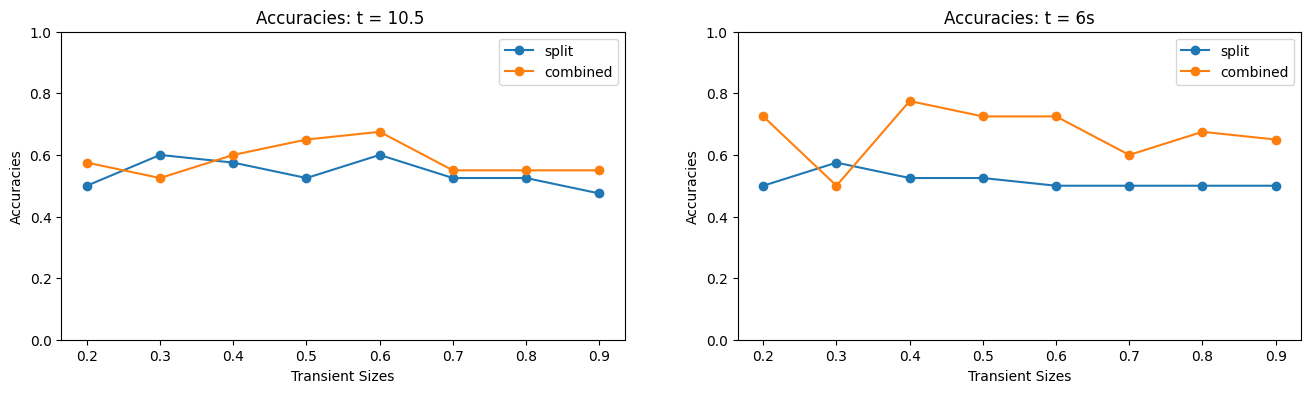

In [6]:
# Plot results
plt.figure(figsize= (16,4))
plt.subplot(121)
plt.plot(transient_size_arr,acc_vec_end[0,:], linestyle = '-', marker = 'o', label = 'split')
plt.plot(transient_size_arr,acc_vec_end[1,:], linestyle = '-', marker = 'o', label = 'combined')
plt.xlabel('Transient Sizes')
plt.ylabel('Accuracies')
plt.ylim([0,1])
plt.legend()
plt.title('Accuracies: t = 10.5 ')

plt.subplot(122)
plt.plot(transient_size_arr,acc_vec_mid[0,:], linestyle = '-', marker = 'o', label = 'split')
plt.plot(transient_size_arr, acc_vec_mid[1,:], linestyle = '-', marker = 'o', label = 'combined')
plt.xlabel('Transient Sizes')
plt.ylabel('Accuracies')
plt.ylim([0,1])
plt.legend()
plt.title('Accuracies: t = 6s')